# Advanced Lane Findig

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

## Helper functions

In [216]:
def read_test_image(filename):  
    return mpimg.imread(os.path.join('test_images', filename))
                       
def save_output_image(image, filename):  
    mpimg.imsave(os.path.join('output_images', filename), image)

def show_before_and_after(before_image, after_image, before_title, after_title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.tight_layout()
    
    if len(before_image.shape) == 3:
        ax1.imshow(before_image)
    else:
        ax1.imshow(before_image, cmap='gray')
    
    ax1.set_title(before_title, fontsize=20)
        
    if len(after_image.shape) == 3:
        ax2.imshow(after_image)
    else:
        ax2.imshow(after_image, cmap='gray')
    
    ax2.set_title(after_title, fontsize=20)
        
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Camera Calibration

In [208]:
def camera_calibration(images, grid_size, image_size):
    objp = np.zeros((grid_size[0] * grid_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:grid_size[0], 0:grid_size[1]].T.reshape(-1, 2)

    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    fig, axs = plt.subplots(5,4, figsize=(16, 11))
    axs = axs.ravel()

    for i, filename in enumerate(images):
        image = mpimg.imread(filename)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, grid_size, None)

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # Draw and display the corners
            image = cv2.drawChessboardCorners(image, (9,6), corners, ret)
            axs[i].axis('off')
            axs[i].imshow(image)
        else:
            print("Unable to find appropriate number of corners on {0}".format(filename))

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    return mtx, dist

Unable to find appropriate number of corners on camera_cal\calibration1.jpg
Unable to find appropriate number of corners on camera_cal\calibration4.jpg
Unable to find appropriate number of corners on camera_cal\calibration5.jpg


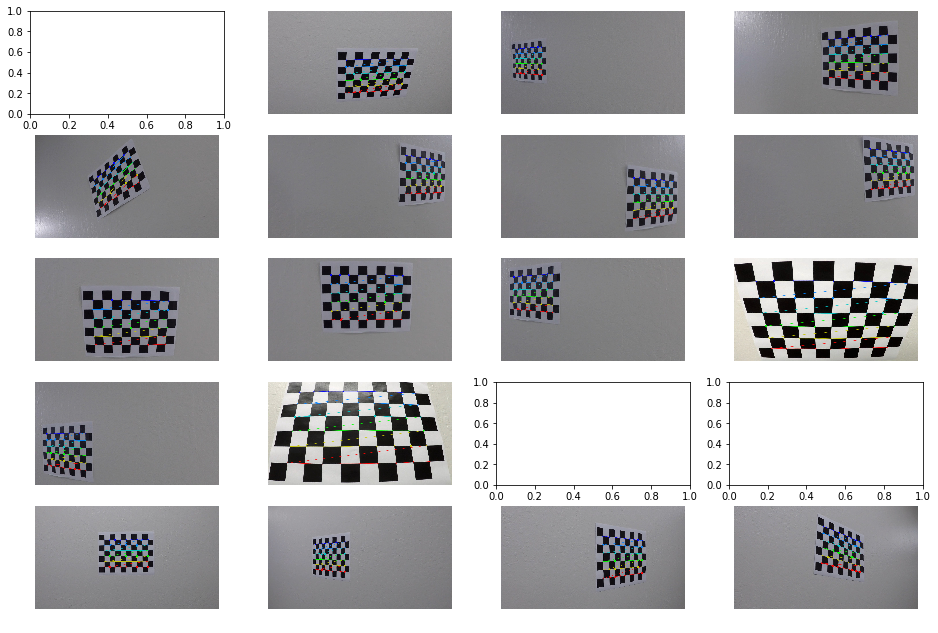

In [175]:
images = glob.glob('camera_cal/calibration*.jpg')
image = mpimg.imread(images[0]) # read first calibration image to obtain the camera's image size, needed for calibration

grid_size = (9, 6) # corner points of the chessboard calibration images 
mtx, dist = camera_calibration(images, grid_size, image.shape[1::-1])

Sample....

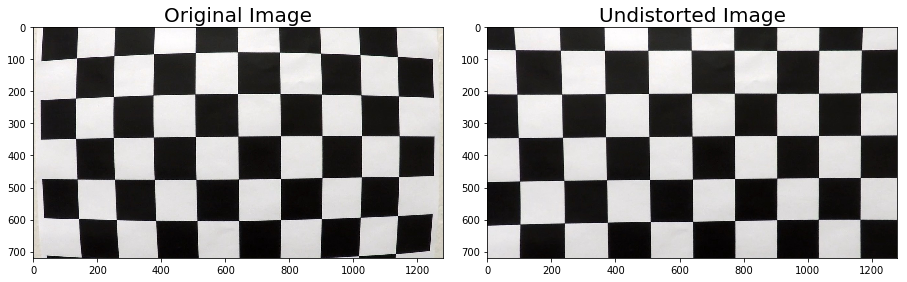

In [176]:
original = mpimg.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(original, mtx, dist, None, mtx)
show_before_and_after(original, undist, before_title="Original Image", after_title = "Undistorted Image")

## Image Pipeline

### Example Image

The image pipeline will be demonstrated with the sample image `test5.jpg`

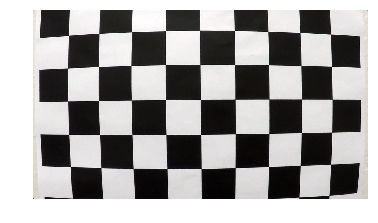

In [177]:
test_image = read_test_image('test5.jpg')
plt.axis('off')
plt.imshow(image)

In [212]:
def read_and_undistort(filename):
    image = read_test_image(filename)
    if image.shape[2] == 4:
        image = image[:,:,:3]
        
    image = cv2.undistort(image, mtx, dist, None, mtx)
    return image

### Step 1: Undistort Image

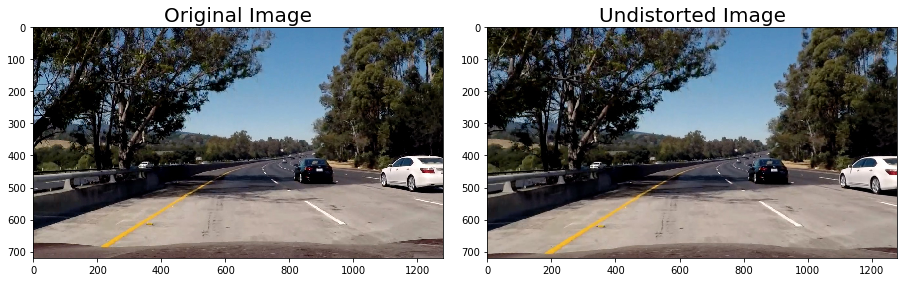

In [217]:
undist = cv2.undistort(test_image, mtx, dist, None, mtx)
show_before_and_after(test_image, undist, before_title="Original Image", after_title = "Undistorted Image")
save_output_image(undist, 'undistored.jpg')

### Step 2: Create Binary Image for Line Detection

In [267]:
def abs_sobel_threshold(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        d = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        d = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_d = np.absolute(d)
    scaled = np.uint8(255*abs_d/np.max(abs_d))
    
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary_output

def mag_threshold(image, kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)

    magnitude = np.sqrt(sobelx **2 + sobely ** 2)
    
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def hls_channel_threshold(image, channel="h", thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    if channel == 'h':
        channel_data = hls[:,:,0]
    elif channel == 'l':
        channel_data = hls[:,:,1]
    else:
        channel_data = hls[:,:,2]
    
    binary = np.zeros_like(channel_data)
    binary[(channel_data >= thresh[0]) & (channel_data <= thresh[1])] = 1
    return binary

def rgb_channel_threshold(image, channel="r", thresh=(0, 255)):
    if channel == 'r':
        channel_data = image[:,:,0]
    elif channel == 'g':
        channel_data = image[:,:,1]
    else:
        channel_data = image[:,:,2]
    
    binary = np.zeros_like(channel_data)
    binary[(channel_data >= thresh[0]) & (channel_data <= thresh[1])] = 1
    return binary

def hsv_channel_threshold(image, channel="h", thresh=(0, 255)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    if channel == 'h':
        channel_data = hsv[:,:,0]
    elif channel == 's':
        channel_data = hsv[:,:,1]
    else:
        channel_data = hsv[:,:,2]
    
    binary = np.zeros_like(channel_data)
    binary[(channel_data >= thresh[0]) & (channel_data <= thresh[1])] = 1
    return binary

### HLS Saturation

In [268]:
from ipywidgets import widgets
from ipywidgets import interact

def show(s_min, s_max):
    color_binary = hls_channel_threshold(test_image, 's', thresh=(s_min, s_max)) * 255
    show_before_and_after(test_image, color_binary, before_title="Original", after_title="HLS Saturation")
    color_binary = cv2.cvtColor(color_binary, cv2.COLOR_GRAY2BGR)
    save_output_image(color_binary, 'hls_saturation.jpg')

interact(show, s_min=widgets.IntSlider(min=0,max=255,step=1,value=160, continuous_update=False, description="Min Color:"),
               s_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max Color:"))

interactive(children=(IntSlider(value=160, continuous_update=False, description='Min Color:', max=255), IntSli…

<function __main__.show(s_min, s_max)>

### HLS Lightness

In [269]:
def show(l_min, l_max):
    color_binary = hls_channel_threshold(test_image, 'l', thresh=(l_min, l_max)) * 255
    show_before_and_after(test_image, color_binary, before_title="Original", after_title="HLS Lightness")
    color_binary = cv2.cvtColor(color_binary, cv2.COLOR_GRAY2BGR)
    save_output_image(color_binary, 'hls_lightness.jpg')

interact(show, l_min=widgets.IntSlider(min=0,max=255,step=1,value=200, continuous_update=False, description="Min Color:"),
               l_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max Color:"))

interactive(children=(IntSlider(value=200, continuous_update=False, description='Min Color:', max=255), IntSli…

<function __main__.show(l_min, l_max)>

### Red Channel

In [270]:
def show(r_min, r_max):
    color_binary = rgb_channel_threshold(test_image, 'r', thresh=(r_min, r_max)) * 255
    show_before_and_after(test_image, color_binary, before_title="Original", after_title="Red Channel")
    color_binary = cv2.cvtColor(color_binary, cv2.COLOR_GRAY2BGR)
    save_output_image(color_binary, 'red_channel.jpg')

interact(show, r_min=widgets.IntSlider(min=0,max=255,step=1,value=215, continuous_update=False, description="Min Color:"),
               r_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max Color:"))

interactive(children=(IntSlider(value=215, continuous_update=False, description='Min Color:', max=255), IntSli…

<function __main__.show(r_min, r_max)>

### HSV Channels

In [271]:
def mask_it(image, h_min, h_max, s_min, s_max, v_min, v_max):
    h_binary = hsv_channel_threshold(image, 'h', thresh=(h_min, h_max))
    s_binary = hsv_channel_threshold(image, 's', thresh=(s_min, s_max))
    v_binary = hsv_channel_threshold(image, 'v', thresh=(v_min, v_max))
    
    combined = np.zeros_like(h_binary)
    combined[((h_binary == 1) & (s_binary == 1) & (v_binary == 1))] = 255
    return combined

def make_multichannel(image):
    return np.uint8(np.dstack([image, image, image]))

def show(h_min, h_max, s_min, s_max, v_min, v_max):
    combined = mask_it(test_image, h_min, h_max, s_min, s_max, v_min, v_max)
    merged = cv2.addWeighted(test_image, 1.0, make_multichannel(combined), 0.7, 0)
    show_before_and_after(test_image, combined, before_title="Original", after_title="HSV Channels")
    combined = cv2.cvtColor(combined, cv2.COLOR_GRAY2BGR)
    save_output_image(combined, 'hsv_channels.jpg')

interact(show, h_min=widgets.IntSlider(min=0,max=255,step=1,value=0, continuous_update=False, description="Min H:"),
               h_max=widgets.IntSlider(min=0,max=178,step=1,value=105, continuous_update=False, description="Max H:"),
               s_min=widgets.IntSlider(min=0,max=255,step=1,value=129, continuous_update=False, description="Min S:"),
               s_max=widgets.IntSlider(min=0,max=255,step=1,value=250, continuous_update=False, description="Max S:"),
               v_min=widgets.IntSlider(min=0,max=255,step=1,value=0, continuous_update=False, description="Min V:"),
               v_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max V:"))

interactive(children=(IntSlider(value=0, continuous_update=False, description='Min H:', max=255), IntSlider(va…

<function __main__.show(h_min, h_max, s_min, s_max, v_min, v_max)>

### RGB Channels

In [272]:
def mask_it(image, r_min, r_max, g_min, g_max, b_min, b_max):
    r_binary = rgb_channel_threshold(image, 'r', thresh=(r_min, r_max))
    g_binary = rgb_channel_threshold(image, 'g', thresh=(g_min, g_max))
    b_binary = rgb_channel_threshold(image, 'b', thresh=(b_min, b_max))
    
    combined = np.zeros_like(r_binary)
    combined[((r_binary == 1) & (g_binary == 1) & (b_binary == 1))] = 255
    return combined

def show(r_min, r_max, g_min, g_max, b_min, b_max):
    combined = mask_it(test_image, r_min, r_max, g_min, g_max, b_min, b_max)
    show_before_and_after(test_image, combined, before_title="Original", after_title="RGB Channels")
    combined = cv2.cvtColor(combined, cv2.COLOR_GRAY2BGR)
    save_output_image(combined, 'rgb_channels.jpg')

interact(show, r_min=widgets.IntSlider(min=0,max=255,step=1,value=206, continuous_update=False, description="Min R:"),
               r_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max R:"),
               g_min=widgets.IntSlider(min=0,max=255,step=1,value=155, continuous_update=False, description="Min G:"),
               g_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max G:"),
               b_min=widgets.IntSlider(min=0,max=255,step=1,value=0, continuous_update=False, description="Min B:"),
               b_max=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max B:"))

interactive(children=(IntSlider(value=206, continuous_update=False, description='Min R:', max=255), IntSlider(…

<function __main__.show(r_min, r_max, g_min, g_max, b_min, b_max)>

### Sobel Magnitude

In [273]:
ksize = 3

def show(min, max):
    mag_binary = mag_threshold(test_image, kernel=ksize, thresh=(min, max)) * 255
    show_before_and_after(test_image, mag_binary, before_title="Original", after_title="Sobel Magnitude")
    mag_binary = cv2.cvtColor(mag_binary, cv2.COLOR_GRAY2BGR)
    save_output_image(mag_binary, 'sobel_magnitude.jpg')

interact(show, min=widgets.IntSlider(min=0,max=255,step=1,value=65, continuous_update=False, description="Min:"),
               max=widgets.IntSlider(min=0,max=255,step=1,value=150, continuous_update=False, description="Max:"))

interactive(children=(IntSlider(value=65, continuous_update=False, description='Min:', max=255), IntSlider(val…

<function __main__.show(min, max)>

### Absolute Sobel X

In [274]:
def show(min, max):
    gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
    abs_sobel_binary = abs_sobel_threshold(gray, orient='x', thresh=(min, max)) * 255
    show_before_and_after(test_image, abs_sobel_binary, before_title="Original", after_title="Absolut Sobel X")
    abs_sobel_binary = cv2.cvtColor(abs_sobel_binary, cv2.COLOR_GRAY2BGR)
    save_output_image(abs_sobel_binary, 'abs_sobel_x.jpg')

interact(show, min=widgets.IntSlider(min=0,max=255,step=1,value=16, continuous_update=False, description="Min:"),
               max=widgets.IntSlider(min=0,max=255,step=1,value=60, continuous_update=False, description="Max:"))

interactive(children=(IntSlider(value=16, continuous_update=False, description='Min:', max=255), IntSlider(val…

<function __main__.show(min, max)>

### Absolute Sobel Y

In [275]:
def show(min, max):
    gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
    abs_sobel_binary = abs_sobel_threshold(gray, orient='y', thresh=(min, max)) * 255
    show_before_and_after(test_image, abs_sobel_binary, before_title="Original", after_title="Absolut Sobel Y")
    abs_sobel_binary = cv2.cvtColor(abs_sobel_binary, cv2.COLOR_GRAY2BGR)
    save_output_image(abs_sobel_binary, 'abs_sobel_y.jpg')

interact(show, min=widgets.IntSlider(min=0,max=255,step=1,value=37, continuous_update=False, description="Min:"),
               max=widgets.IntSlider(min=0,max=255,step=1,value=65, continuous_update=False, description="Max:"))

interactive(children=(IntSlider(value=37, continuous_update=False, description='Min:', max=255), IntSlider(val…

<function __main__.show(min, max)>

### Final Binary Image

In [276]:
def get_binary_image(image, s_max=6, l_max=78, gradx_l_min=17, gradx_l_max=40, gradx_s_min=7, gradx_s_max=47):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S = hls[:, :, 2]
    L = hls[:, :, 1]

    light_mask = np.zeros_like(L)
    light_mask[(S >= s_max) & (L >= l_max)] = 1

    gradx_l = abs_sobel_threshold(L, orient='x', sobel_kernel=3, thresh=(gradx_l_min, gradx_l_max))
    gradx_s = abs_sobel_threshold(S, orient='x', sobel_kernel=3, thresh=(gradx_s_min, gradx_s_max))

    binary_image = np.zeros_like(gradx_s)
    binary_image[((gradx_l == 1) | (gradx_s == 1)) & (light_mask == 1)] = 255
    return binary_image
    
def show(s_max, l_max, gradx_l_min, gradx_l_max, gradx_s_min, gradx_s_max):
    binary_image = get_binary_image(test_image, s_max, l_max, gradx_l_min, gradx_l_max, gradx_s_min, gradx_s_max)
    show_before_and_after(test_image, binary_image, before_title="Original", after_title="Final Binary Image")
    binary_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
    save_output_image(binary_image, 'final_binary.jpg')

interact(show,  s_max=widgets.IntSlider(min=0,max=255,step=1,value=6, continuous_update=False, description="S Max:"),
                l_max=widgets.IntSlider(min=0,max=255,step=1,value=78, continuous_update=False, description="L Max:"),
                gradx_l_min=widgets.IntSlider(min=0,max=255,step=1,value=17, continuous_update=False, description="GX L Min:"),
                gradx_l_max=widgets.IntSlider(min=0,max=255,step=1,value=40, continuous_update=False, description="GX L Max:"),
                gradx_s_min=widgets.IntSlider(min=0,max=255,step=1,value=7, continuous_update=False, description="GX S Min:"),
                gradx_s_max=widgets.IntSlider(min=0,max=255,step=1,value=47, continuous_update=False, description="GX S Max:"))

interactive(children=(IntSlider(value=6, continuous_update=False, description='S Max:', max=255), IntSlider(va…

<function __main__.show(s_max, l_max, gradx_l_min, gradx_l_max, gradx_s_min, gradx_s_max)>

### Step 3: Perspective Transformation

Text(0.5,1,'Warped Binary Image')

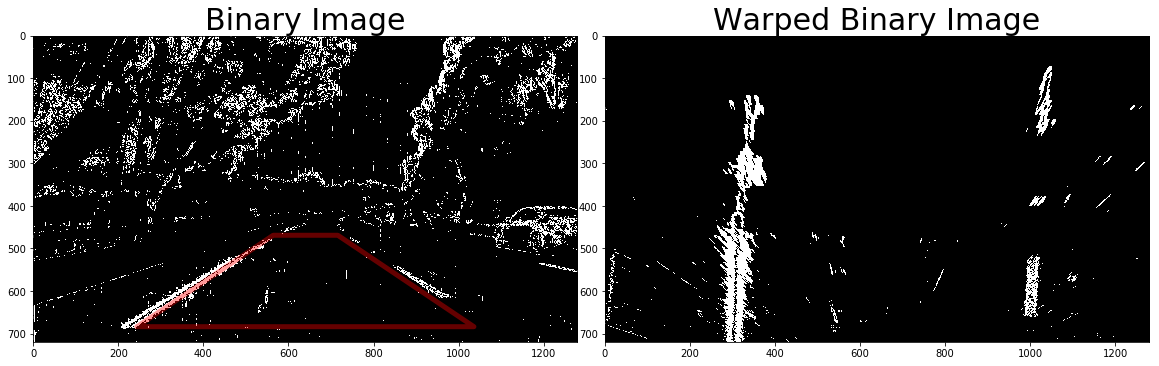

In [170]:
def get_src_points(image_size):
    height, width = image_size
    midpoint = width // 2
    bottom = height - int(height * 0.05)  # small distance from bottom
    top_distance = int(width * .06)
    bottom_distance = int(width * .31)
    points = np.float32([(midpoint - bottom_distance, bottom),
                         (midpoint - top_distance, height - int(height * .35)),
                         (midpoint + top_distance, height - int(height * .35)),
                         (midpoint + bottom_distance, bottom)])
    return points

def get_dst_points(image_size):
    height, width = image_size
    margin = width / 4
    dst = np.float32([[margin, height],
                      [margin, 0],
                      [width - margin, 0],
                      [width - margin, height]])
    return dst

def get_warp_matrices(src_points, dst_points):
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    return M, Minv
        
def warp(image):
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size)
    return warped

def unwarp(image):
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, invM, img_size)
    return warped

binary_image = get_binary_image(test_image)

# build vertices for perspective transformation
src = get_src_points(binary_image.shape)
dst = get_dst_points(binary_image.shape)

# build warp matrix and inverse warp matrix
M, invM = get_warp_matrices(src, dst)

birds_eye = warp(binary_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(binary_image, cmap="gray")
x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
ax1.plot(x, y, color='Red', alpha=0.4, linewidth=5, solid_capstyle='round', zorder=2)
ax1.set_title('Binary Image', fontsize=30)
ax2.imshow(birds_eye, cmap="gray")
ax2.set_title('Warped Binary Image', fontsize=30)